# MANA-8: Hierarchical Clustering with Local Refinement

## Problem
When clustering all samples together, we lose sample-specific nuances (e.g., grey/white matter separation in Peak III samples like S3_B3_O and S3_B1_2).

## Strategy: Hierarchical Clustering with Local Refinement

**Approach 1: Sub-clustering within global clusters**
- Keep global clusters as "coarse" labels
- Sub-cluster problematic samples/regions to capture local structure
- Create hierarchical labels (e.g., "cluster_3.1", "cluster_3.2")

**Approach 2: Local clustering + Label Transfer**
- Cluster problematic samples independently (as you did before with subset)
- Use label transfer to map local clusters to global reference
- Merge labels strategically

**Approach 3: Weighted Consensus**
- Cluster each sample independently
- Find consensus across samples using label harmonization
- Preserve local structure while maintaining cross-sample consistency

We'll implement **Approach 1** (sub-clustering) as the primary strategy, with options for the others.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Import MANA utils
import sys
sys.path.insert(0, '..')
from utils import aggregate_neighbors_weighted, plot_spatial_compact_fast

## Part 1: Load Data and Identify Problematic Samples

In [2]:
# Load the full dataset with MANA clustering
adata = sc.read_h5ad('/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_scVI_mana_embedding_clustered2.h5ad')

print(f"Loaded: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"\nAvailable cluster columns:")
for col in adata.obs.columns:
    if 'leiden' in col.lower() or 'cluster' in col.lower() or 'louvain' in col.lower():
        print(f"  - {col}: {adata.obs[col].nunique()} clusters")

Loaded: 877,141 cells × 5,101 genes

Available cluster columns:
  - proseg_cluster: 3 clusters
  - louvain_0.5: 15 clusters
  - louvain_1: 26 clusters
  - louvain_1.5: 32 clusters
  - louvain_2: 46 clusters
  - louvain_2.5: 54 clusters
  - louvain_3: 59 clusters
  - louvain_3.5: 66 clusters
  - Cluster: 66 clusters
  - leiden_0.5: 17 clusters
  - leiden_1: 27 clusters
  - leiden_1.5: 36 clusters
  - leiden_2: 47 clusters
  - leiden_2.5: 56 clusters
  - leiden_3: 62 clusters
  - leiden_3.5: 76 clusters
  - cytetype_annotation_louvain_3.5: 66 clusters
  - cytetype_cellOntologyTerm_louvain_3.5: 37 clusters
  - cluster_id: 66 clusters
  - cluster_cellcharter_auto: 4 clusters
  - cluster_cellcharter_13: 13 clusters
  - cluster_cellcharter_15: 15 clusters
  - cluster_cellcharter_9: 9 clusters
  - cluster_cellcharter_30: 30 clusters
  - cluster_cellcharter_50: 50 clusters
  - cluster_cellcharter_25: 25 clusters
  - cluster_cellcharter_2: 2 clusters
  - cluster_cellcharter_5: 5 clusters
  - cl

In [7]:
# Identify the problematic samples
# These are Peak III samples where grey matter doesn't separate well
problematic_samples = ['S3_B3_0', 'S3_B1_2']  # Add more as needed

# Check sample column name
sample_col = None
for col in ['sample_id', 'sample', 'section', 'slide_id']:
    if col in adata.obs.columns:
        sample_col = col
        break

if sample_col is None:
    print("Available columns:", list(adata.obs.columns))
    sample_col = input("Enter the sample column name: ")

print(f"Using sample column: {sample_col}")
print(f"\nAll samples ({adata.obs[sample_col].nunique()}):")
print(adata.obs[sample_col].value_counts())

Using sample column: sample_id

All samples (107):
sample_id
G3_L1_1    19257
S3_B3_0    17380
S2_T1_1    15695
S3_B2_0    15297
S1_B1_0    13844
           ...  
S1_T2_0     4183
G5_L2_2     4182
G6_L2_0     4136
S2_T2_2     3824
G5_L1_0     3044
Name: count, Length: 107, dtype: int64


In [8]:
# Verify problematic samples exist
available_samples = adata.obs[sample_col].unique()
problematic_samples = [s for s in problematic_samples if s in available_samples]

if len(problematic_samples) == 0:
    print("WARNING: None of the specified problematic samples found!")
    print("Available samples:", list(available_samples))
else:
    print(f"Problematic samples to refine: {problematic_samples}")
    for s in problematic_samples:
        n_cells = (adata.obs[sample_col] == s).sum()
        print(f"  - {s}: {n_cells:,} cells")

Problematic samples to refine: ['S3_B3_0', 'S3_B1_2']
  - S3_B3_0: 17,380 cells
  - S3_B1_2: 11,624 cells


## Part 2: Approach 1 - Sub-clustering Within Global Clusters

For problematic samples, we'll:
1. Extract cells from those samples
2. Re-cluster at higher resolution using MANA features
3. Create hierarchical labels that preserve global structure but add local refinement

In [9]:
# Define which cluster column to use as the base
# Look for MANA-based clustering
base_cluster_col = None
for col in adata.obs.columns:
    if 'mana' in col.lower() and 'leiden' in col.lower():
        base_cluster_col = col
        break

if base_cluster_col is None:
    # Fall back to any leiden column
    for col in adata.obs.columns:
        if 'leiden' in col.lower():
            base_cluster_col = col
            break

print(f"Base cluster column: {base_cluster_col}")
print(f"Number of global clusters: {adata.obs[base_cluster_col].nunique()}")

Base cluster column: leiden_mana_0.3
Number of global clusters: 16


In [10]:
def subcluster_samples(
    adata,
    samples,
    sample_col,
    base_cluster_col,
    use_rep='X_mana_gauss',
    resolution=1.0,
    n_neighbors=15,
    min_cells_for_subcluster=100,
):
    """
    Sub-cluster specific samples to capture local structure.
    
    Returns a new column with hierarchical labels:
    - For non-problematic samples: keeps original cluster label
    - For problematic samples: creates sub-labels like "3_sub1", "3_sub2"
    """
    # Create output column initialized with base clusters
    refined_labels = adata.obs[base_cluster_col].astype(str).copy()
    
    for sample in samples:
        print(f"\nProcessing sample: {sample}")
        
        # Get cells from this sample
        mask = adata.obs[sample_col] == sample
        n_cells = mask.sum()
        print(f"  Cells: {n_cells:,}")
        
        if n_cells < min_cells_for_subcluster:
            print(f"  Skipping (too few cells)")
            continue
        
        # Extract subset
        adata_sub = adata[mask].copy()
        
        # Check if representation exists
        if use_rep not in adata_sub.obsm:
            print(f"  WARNING: {use_rep} not found, using X_scVI")
            use_rep_actual = 'X_scVI' if 'X_scVI' in adata_sub.obsm else None
            if use_rep_actual is None:
                print(f"  ERROR: No suitable representation found, skipping")
                continue
        else:
            use_rep_actual = use_rep
        
        # Build neighborhood graph on MANA features
        sc.pp.neighbors(adata_sub, use_rep=use_rep_actual, n_neighbors=n_neighbors)
        
        # Cluster at higher resolution
        sc.tl.leiden(adata_sub, resolution=resolution, key_added='subcluster')
        
        n_subclusters = adata_sub.obs['subcluster'].nunique()
        print(f"  Found {n_subclusters} sub-clusters at resolution {resolution}")
        
        # Create hierarchical labels
        # For each cell, combine base cluster with sub-cluster
        for idx, (cell_idx, row) in enumerate(adata_sub.obs.iterrows()):
            base_label = str(row[base_cluster_col])
            sub_label = str(row['subcluster'])
            # Create hierarchical label: "baseCluster_subX"
            refined_labels.loc[cell_idx] = f"{base_label}_sub{sub_label}"
        
        # Print distribution
        sub_dist = adata_sub.obs['subcluster'].value_counts()
        print(f"  Sub-cluster sizes: {dict(sub_dist.head(10))}")
    
    return refined_labels

In [11]:
# Run sub-clustering on problematic samples
# Try different resolutions to find good separation

refined_labels = subcluster_samples(
    adata,
    samples=problematic_samples,
    sample_col=sample_col,
    base_cluster_col=base_cluster_col,
    use_rep='X_mana_gauss',  # Use MANA features
    resolution=0.8,  # Higher resolution for finer structure
    n_neighbors=15,
)

# Add to adata
adata.obs['leiden_mana_refined'] = refined_labels

print(f"\nTotal refined clusters: {adata.obs['leiden_mana_refined'].nunique()}")


Processing sample: S3_B3_0
  Cells: 17,380


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_16301/2094510067.py:50: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_sub, resolution=resolution, key_added='subcluster')


  Found 18 sub-clusters at resolution 0.8
  Sub-cluster sizes: {'0': np.int64(2647), '1': np.int64(2138), '2': np.int64(2028), '3': np.int64(1856), '4': np.int64(1482), '5': np.int64(1430), '6': np.int64(1066), '7': np.int64(1056), '8': np.int64(685), '9': np.int64(644)}

Processing sample: S3_B1_2
  Cells: 11,624
  Found 19 sub-clusters at resolution 0.8
  Sub-cluster sizes: {'0': np.int64(1307), '1': np.int64(1125), '2': np.int64(1105), '3': np.int64(1081), '4': np.int64(1015), '5': np.int64(887), '6': np.int64(852), '7': np.int64(724), '8': np.int64(639), '9': np.int64(509)}

Total refined clusters: 108



=== S3_B3_0 ===


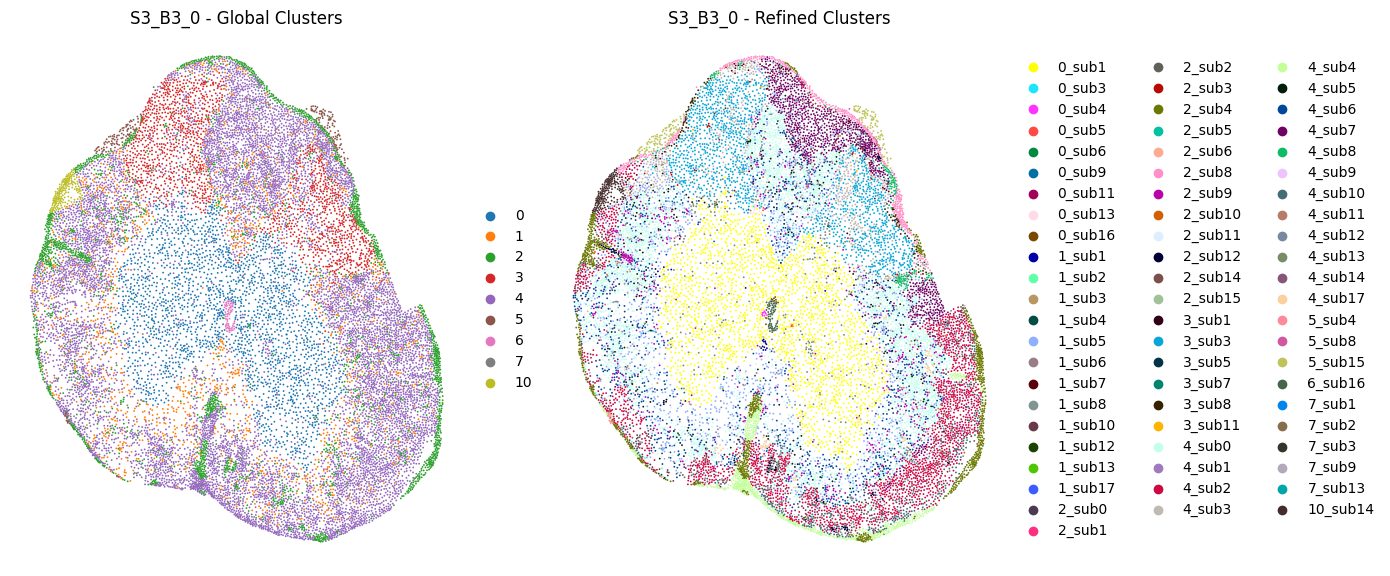


=== S3_B1_2 ===


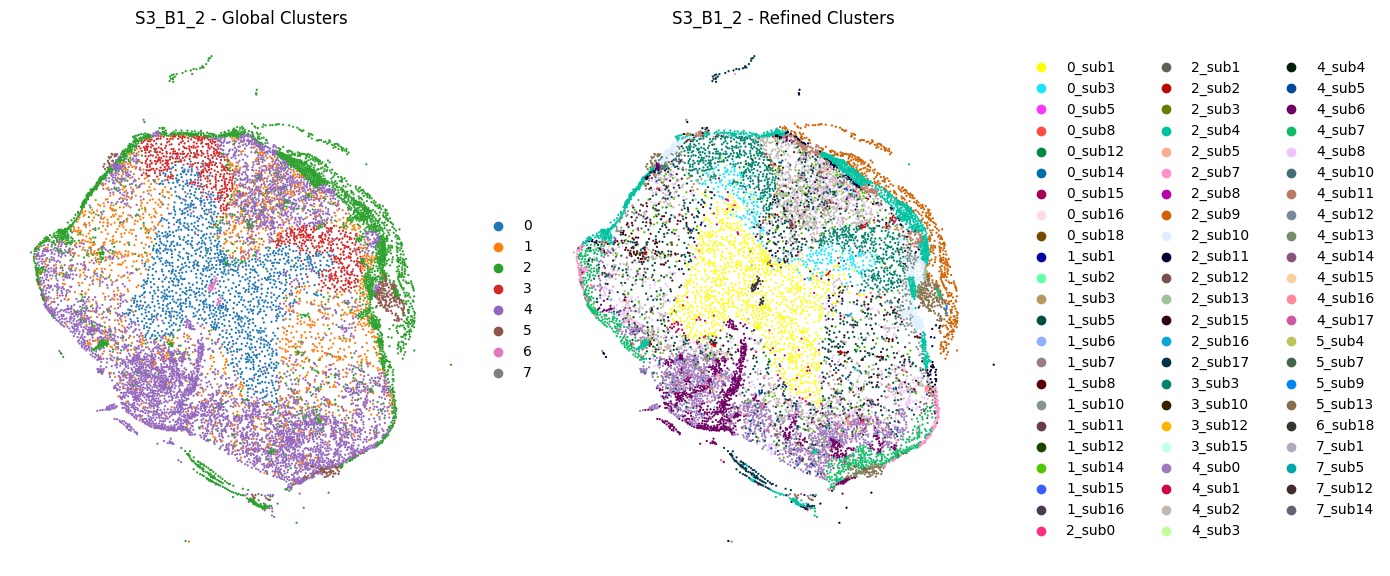

In [12]:
# Visualize the refined clustering for problematic samples
for sample in problematic_samples:
    print(f"\n=== {sample} ===")
    
    # Filter to this sample
    adata_sample = adata[adata.obs[sample_col] == sample].copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Original clustering
    sc.pl.embedding(
        adata_sample,
        basis='spatial',
        color=base_cluster_col,
        ax=axes[0],
        show=False,
        title=f'{sample} - Global Clusters',
        frameon=False,
    )
    
    # Refined clustering
    sc.pl.embedding(
        adata_sample,
        basis='spatial',
        color='leiden_mana_refined',
        ax=axes[1],
        show=False,
        title=f'{sample} - Refined Clusters',
        frameon=False,
    )
    
    plt.tight_layout()
    plt.show()

## Part 3: Approach 2 - Independent Clustering + Label Transfer

Alternative approach:
1. Cluster problematic samples independently (like you did with the subset)
2. Use the good clustering as reference
3. Transfer labels to harmonize with global clustering

In [13]:
def cluster_sample_independently(
    adata,
    sample,
    sample_col,
    use_rep='X_scVI',
    n_layers=3,
    hop_decay=0.2,
    distance_kernel='gaussian',
    resolution=0.5,
):
    """
    Cluster a single sample independently using the full MANA pipeline.
    This replicates what you did with the subset that worked well.
    """
    print(f"\nClustering {sample} independently...")
    
    # Extract sample
    mask = adata.obs[sample_col] == sample
    adata_sample = adata[mask].copy()
    print(f"  Cells: {adata_sample.n_obs:,}")
    
    # Check if spatial graph exists, if not build it
    if 'spatial_connectivities' not in adata_sample.obsp:
        import squidpy as sq
        sq.gr.spatial_neighbors(adata_sample, coord_type='generic', delaunay=True)
        print("  Built spatial graph")
    
    # Run MANA aggregation
    aggregate_neighbors_weighted(
        adata_sample,
        n_layers=n_layers,
        aggregations='mean',
        use_rep=use_rep,
        out_key='X_mana_local',
        hop_decay=hop_decay,
        distance_kernel=distance_kernel,
        spatial_key='spatial',
        normalize_weights=True,
        include_self=True,
    )
    print("  MANA aggregation complete")
    
    # Cluster
    sc.pp.neighbors(adata_sample, use_rep='X_mana_local', n_neighbors=15)
    sc.tl.leiden(adata_sample, resolution=resolution, key_added='leiden_local')
    
    n_clusters = adata_sample.obs['leiden_local'].nunique()
    print(f"  Found {n_clusters} clusters at resolution {resolution}")
    
    return adata_sample

In [14]:
# Cluster problematic samples independently
independent_results = {}

for sample in problematic_samples:
    adata_sample = cluster_sample_independently(
        adata,
        sample=sample,
        sample_col=sample_col,
        use_rep='X_scVI',
        n_layers=3,
        hop_decay=0.2,
        distance_kernel='gaussian',
        resolution=0.5,
    )
    independent_results[sample] = adata_sample


Clustering S3_B3_0 independently...
  Cells: 17,380
  MANA aggregation complete
  Found 12 clusters at resolution 0.5

Clustering S3_B1_2 independently...
  Cells: 11,624
  MANA aggregation complete
  Found 14 clusters at resolution 0.5



=== S3_B3_0 ===


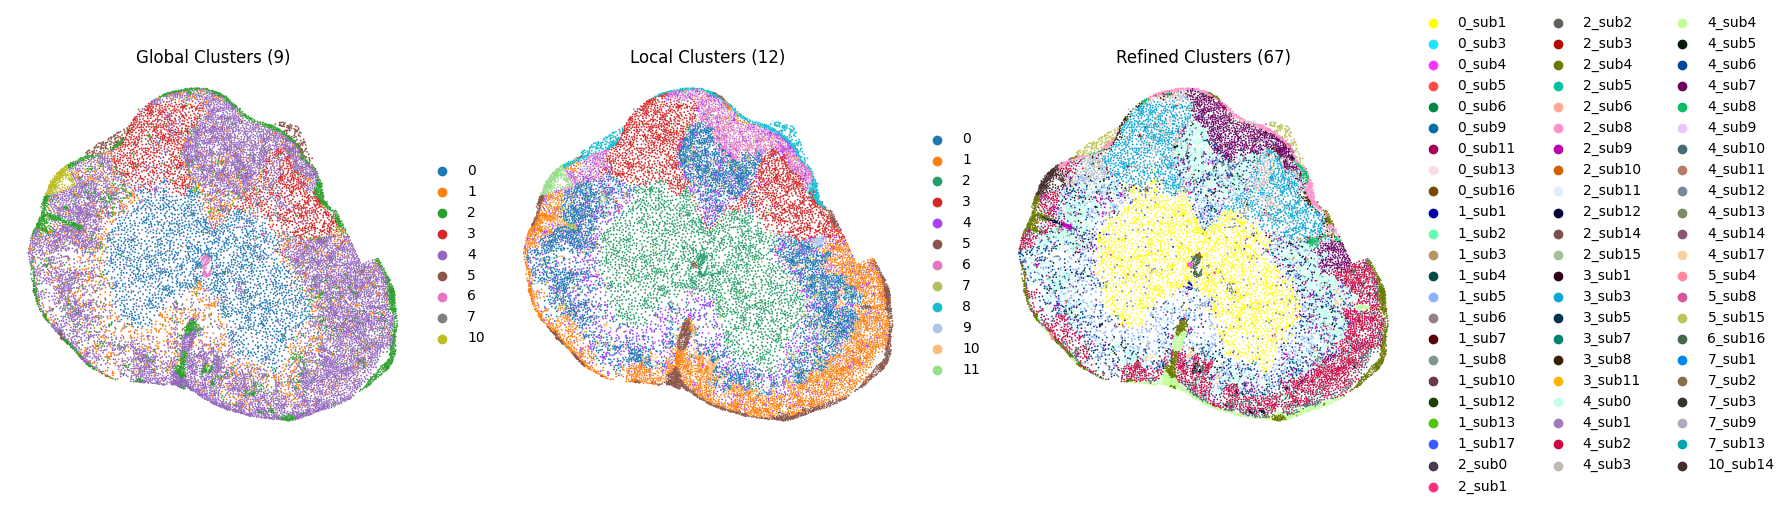


=== S3_B1_2 ===


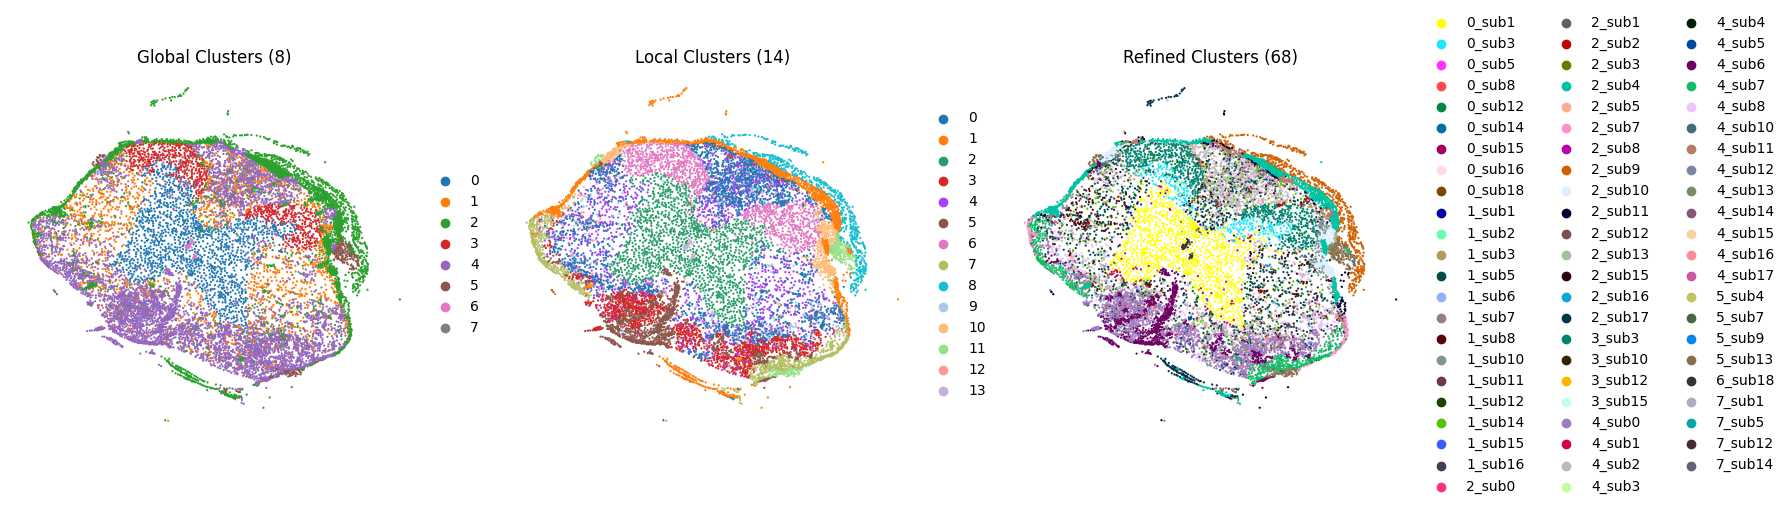

In [15]:
# Compare global vs local clustering for each problematic sample
for sample, adata_sample in independent_results.items():
    print(f"\n=== {sample} ===")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Global clustering
    sc.pl.embedding(
        adata_sample,
        basis='spatial',
        color=base_cluster_col,
        ax=axes[0],
        show=False,
        title=f'Global Clusters ({adata_sample.obs[base_cluster_col].nunique()})',
        frameon=False,
    )
    
    # Local clustering (what we just computed)
    sc.pl.embedding(
        adata_sample,
        basis='spatial',
        color='leiden_local',
        ax=axes[1],
        show=False,
        title=f'Local Clusters ({adata_sample.obs["leiden_local"].nunique()})',
        frameon=False,
    )
    
    # Sub-clustered (from Approach 1)
    if 'leiden_mana_refined' in adata_sample.obs:
        sc.pl.embedding(
            adata_sample,
            basis='spatial',
            color='leiden_mana_refined',
            ax=axes[2],
            show=False,
            title=f'Refined Clusters ({adata_sample.obs["leiden_mana_refined"].nunique()})',
            frameon=False,
        )
    
    plt.tight_layout()
    plt.show()

### Label Transfer: Map Local Clusters to Global Reference

Now we need to decide how to integrate the local clusters back into the global annotation.

In [16]:
def transfer_local_to_global(
    adata,
    local_results,
    sample_col,
    global_cluster_col,
    local_cluster_col='leiden_local',
    strategy='replace',  # 'replace', 'hybrid', or 'keep_both'
):
    """
    Transfer local clustering results back to global adata.
    
    Strategies:
    - 'replace': Replace global labels with local labels for these samples
    - 'hybrid': Create new labels that combine global context with local detail
    - 'keep_both': Keep both columns for comparison
    """
    # Create new column
    new_labels = adata.obs[global_cluster_col].astype(str).copy()
    
    for sample, adata_local in local_results.items():
        print(f"\nTransferring labels from {sample}...")
        
        mask = adata.obs[sample_col] == sample
        cell_indices = adata.obs.index[mask]
        
        if strategy == 'replace':
            # Simply use local labels with a prefix
            for cell_id in cell_indices:
                if cell_id in adata_local.obs.index:
                    local_label = adata_local.obs.loc[cell_id, local_cluster_col]
                    new_labels.loc[cell_id] = f"{sample}_{local_label}"
                    
        elif strategy == 'hybrid':
            # Combine global and local labels
            for cell_id in cell_indices:
                if cell_id in adata_local.obs.index:
                    global_label = adata.obs.loc[cell_id, global_cluster_col]
                    local_label = adata_local.obs.loc[cell_id, local_cluster_col]
                    new_labels.loc[cell_id] = f"{global_label}_local{local_label}"
        
        n_unique = new_labels.loc[cell_indices].nunique()
        print(f"  Created {n_unique} unique labels for {sample}")
    
    return new_labels

In [17]:
# Apply label transfer with hybrid strategy
hybrid_labels = transfer_local_to_global(
    adata,
    independent_results,
    sample_col=sample_col,
    global_cluster_col=base_cluster_col,
    local_cluster_col='leiden_local',
    strategy='hybrid',
)

adata.obs['leiden_mana_hybrid'] = hybrid_labels

print(f"\nTotal hybrid clusters: {adata.obs['leiden_mana_hybrid'].nunique()}")


Transferring labels from S3_B3_0...
  Created 51 unique labels for S3_B3_0

Transferring labels from S3_B1_2...
  Created 54 unique labels for S3_B1_2

Total hybrid clusters: 85


## Part 4: Evaluate and Compare Approaches

In [18]:
def local_purity(adata, cluster_key):
    """Compute spatial coherence: fraction of neighbors with same cluster label."""
    if 'spatial_connectivities' not in adata.obsp:
        return np.nan
    
    conn = adata.obsp['spatial_connectivities']
    labels = adata.obs[cluster_key].astype('category').cat.codes.values
    purities = []
    
    for i in range(adata.n_obs):
        neighbors = conn[i].nonzero()[1]
        if len(neighbors) > 0:
            neighbor_labels = labels[neighbors]
            purity = (neighbor_labels == labels[i]).mean()
            purities.append(purity)
    
    return np.mean(purities) if len(purities) > 0 else np.nan


# Compare purity for problematic samples
print("\n=== Local Purity Comparison ===")
print(f"{'Sample':<15} {'Global':<12} {'Refined':<12} {'Hybrid':<12}")
print("-" * 55)

for sample in problematic_samples:
    adata_sample = adata[adata.obs[sample_col] == sample].copy()
    
    purity_global = local_purity(adata_sample, base_cluster_col)
    
    purity_refined = np.nan
    if 'leiden_mana_refined' in adata_sample.obs:
        purity_refined = local_purity(adata_sample, 'leiden_mana_refined')
    
    purity_hybrid = np.nan
    if 'leiden_mana_hybrid' in adata_sample.obs:
        purity_hybrid = local_purity(adata_sample, 'leiden_mana_hybrid')
    
    print(f"{sample:<15} {purity_global:<12.3f} {purity_refined:<12.3f} {purity_hybrid:<12.3f}")


=== Local Purity Comparison ===
Sample          Global       Refined      Hybrid      
-------------------------------------------------------
S3_B3_0         0.714        0.539        0.594       
S3_B1_2         0.737        0.573        0.618       


## Part 5: Create Final Merged Labels

Based on the evaluation, create the final label column that:
- Uses global clusters for samples that work well
- Uses refined/local clusters for problematic samples

In [19]:
def create_final_labels(
    adata,
    sample_col,
    problematic_samples,
    global_col,
    local_col,
):
    """
    Create final labels using:
    - Global clusters for normal samples
    - Local/refined clusters for problematic samples
    """
    final_labels = adata.obs[global_col].astype(str).copy()
    
    for sample in problematic_samples:
        mask = adata.obs[sample_col] == sample
        final_labels.loc[mask] = adata.obs.loc[mask, local_col].astype(str)
        print(f"Using local labels for {sample}: {final_labels.loc[mask].nunique()} clusters")
    
    return final_labels


# Choose which local approach worked better
# Options: 'leiden_mana_refined' (sub-clustering) or 'leiden_mana_hybrid' (independent + transfer)
best_local_col = 'leiden_mana_refined'  # Change based on your evaluation

adata.obs['leiden_mana_final'] = create_final_labels(
    adata,
    sample_col=sample_col,
    problematic_samples=problematic_samples,
    global_col=base_cluster_col,
    local_col=best_local_col,
)

print(f"\nFinal clustering: {adata.obs['leiden_mana_final'].nunique()} clusters")

Using local labels for S3_B3_0: 67 clusters
Using local labels for S3_B1_2: 68 clusters

Final clustering: 108 clusters


In [ ]:
# Final visualization of problematic samples
for sample in problematic_samples:
    adata_sample = adata[adata.obs[sample_col] == sample].copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Before
    sc.pl.embedding(
        adata_sample,
        basis='spatial',
        color=base_cluster_col,
        ax=axes[0],
        show=False,
        title=f'{sample} - BEFORE (Global)',
        frameon=False,
    )
    
    # After
    sc.pl.embedding(
        adata_sample,
        basis='spatial',
        color='leiden_mana_final',
        ax=axes[1],
        show=False,
        title=f'{sample} - AFTER (Final)',
        frameon=False,
    )
    
    plt.tight_layout()
    plt.show()

## Part 6: Save Results

In [ ]:
# Summary of new columns added
print("New clustering columns added:")
for col in ['leiden_mana_refined', 'leiden_mana_hybrid', 'leiden_mana_final']:
    if col in adata.obs:
        print(f"  - {col}: {adata.obs[col].nunique()} clusters")

In [ ]:
# Save the updated data
output_path = '/Volumes/processing2/RRmap/data/EAE_proseg_MANA_refined_clustering.h5ad'

# Clean up .uns if needed
keys_to_remove = [k for k in adata.uns.keys() if 'jobDetails' in k or 'auth_token' in str(adata.uns.get(k, ''))]
for k in keys_to_remove:
    del adata.uns[k]

adata.write_h5ad(output_path)
print(f"Saved to: {output_path}")

## Summary

This notebook implements a hierarchical approach to handle samples where global clustering fails to capture local structure:

**Approach 1 (Sub-clustering):**
- Keep global cluster assignments
- Sub-divide clusters in problematic samples
- Results in `leiden_mana_refined`

**Approach 2 (Independent + Transfer):**
- Cluster problematic samples independently with full MANA pipeline
- Transfer labels back with global context
- Results in `leiden_mana_hybrid`

**Final Strategy:**
- Use global clusters for most samples
- Use local/refined clusters for problematic samples
- Results in `leiden_mana_final`

### Next Steps
1. Manually identify more problematic samples if needed
2. Tune resolution parameters for each sample type
3. Consider tissue-type-specific clustering if annotations available